In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

s3_path_train = 's3://placeholder/data/train.csv'

2025-03-21 17:38:45.269148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# load data from s3 bucket
train = pd.read_csv(s3_path_train)

In [6]:
X_train = [x for x in train['Document']]
y_train = [x for x in train['Topic_group']]

In [9]:
len(X_train), len(y_train)

(26907, 26907)

<BarContainer object of 8 artists>

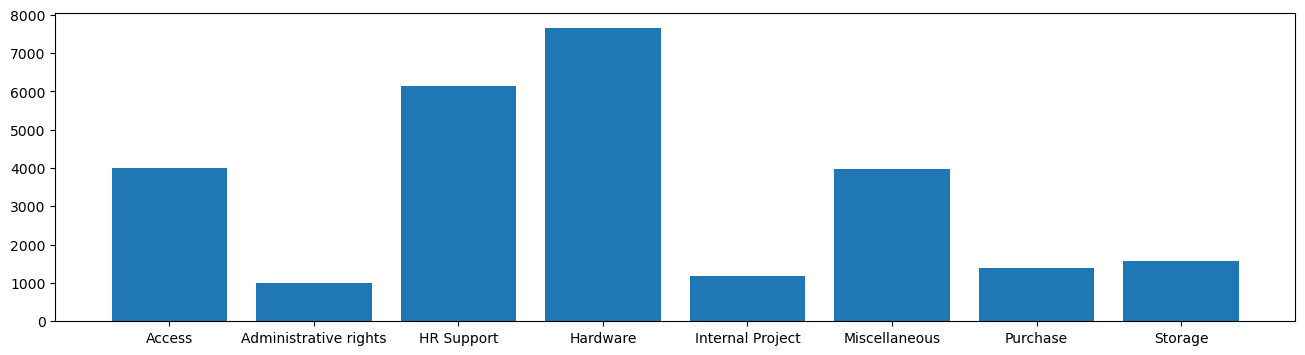

In [ ]:
# class distribution
plt.figure(figsize=(16,4))
plt.bar(np.unique(y_train, return_counts=True)[0], np.unique(y_train, return_counts=True)[1])

### Embeddings Distribution on a low dimensionality space

In [18]:
embeddings = model.encode(X_train)

In [19]:
embeddings.shape

(26907, 384)

In [20]:
from sklearn.decomposition import PCA

In [ ]:
# reduce dimensionality with pca
pca = PCA(n_components=2)
low_emb = pca.fit_transform(embeddings)

In [25]:
low_emb.shape

(26907, 2)

In [26]:
viz_df = pd.DataFrame(low_emb, columns=['x', 'y'])

In [29]:
viz_df['label'] = y_train

plot embeddings distribution

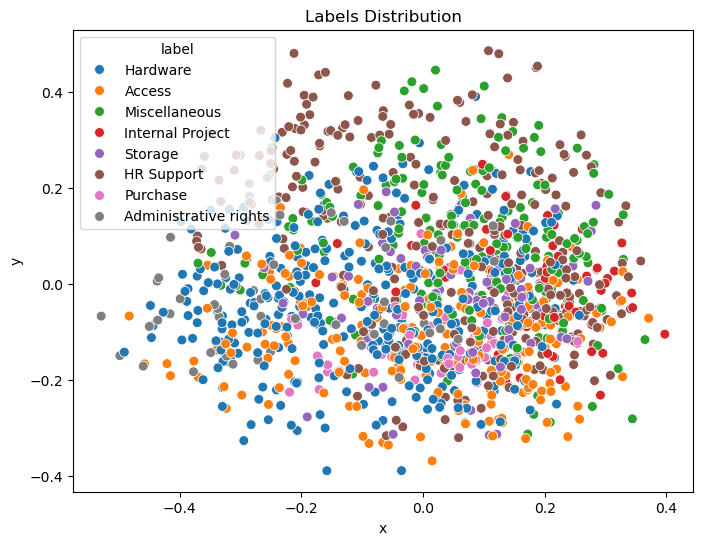

In [63]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=viz_df.sample(frac=0.05), x='x', y='y', hue='label', s=50)
plt.title("Labels Distribution")
plt.show()

Not so useful :(

## Centroid Based Visualization

In [37]:
centroid_df = pd.DataFrame(embeddings)
centroid_df['labels'] = y_train

In [ ]:
# calculate centroids and std for each class
mean_df = centroid_df.groupby('labels').mean()
std_df = centroid_df.groupby('labels').std()

In [39]:
mean_df.shape, std_df.shape

((8, 384), (8, 384))

In [ ]:
# apply pca to centroids and std
pca = PCA(n_components=2)
viz_mean = pca.fit_transform(mean_df)
viz_std = pca.fit_transform(std_df)

In [52]:
viz_mean_df = pd.DataFrame(viz_mean, columns=['x', 'y'])
viz_mean_df['label'] = mean_df.index

viz_std_df = pd.DataFrame(viz_std, columns=['x', 'y'])
viz_std_df['label'] = std_df.index

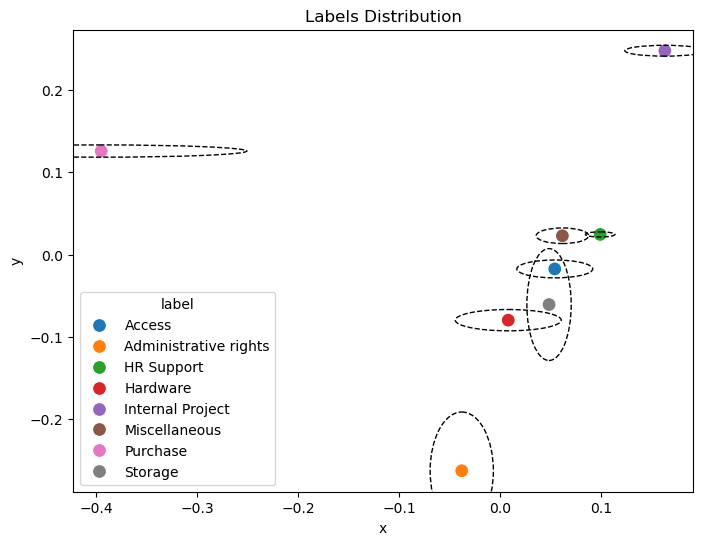

In [ ]:
from matplotlib.patches import Ellipse

# plot centroids with ellipses representing class spread
plt.figure(figsize=(8, 6))
sns.scatterplot(data=viz_mean_df, x='x', y='y', hue='label', s=100)
plt.title("Labels Distribution")

# add ellipses to show class variance
ax = plt.gca()
for i in range(viz_std_df.shape[0]):
    center = viz_mean_df.iloc[i]
    std = viz_std_df.iloc[i]
    ellipse = Ellipse(xy=(center['x'], center['y']), width=2*std['x'], height=2*std['y'],
                      edgecolor='black', facecolor='none', linestyle='dashed')
    ax.add_patch(ellipse)


plt.show()

### Observations:
- Storage class overlaps with the Hardware class and the Access class.
- There is a small overlapping between the Miscellaneous class and the HR support class.
- The HR support class has a relatively small std.
- The Purchase, Internal Project, and Administrative Rights classes appear to be the most distinctively characterized.